In [97]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torchvision.models as models
import torch.nn as nn
from torch.utils.data import ConcatDataset, DataLoader, Subset, Dataset
from sklearn.model_selection import train_test_split
from tqdm.auto import tqdm
import scipy.io
import os

In [98]:
matlib = '/Users/mclinwong/GitHub/CodesReproduction/DCN-DOA/ReproducedCodes/matlib'
figure_savepath = '/Users/mclinwong/GitHub/CodesReproduction/DCN-DOA/ReproducedCodes/Figures/'
device = torch.device("cuda:0" if torch.cuda.is_available() else "mps")
num_epoch = 600
batch_size = 64

In [99]:
datapath = os.path.join(matlib, 'data2_trainlow.mat')
read_data = scipy.io.loadmat(datapath)
S_est = read_data['S_est']
S_abs = read_data['S_abs']
S_label = read_data['S_label']
R_est = read_data['R_est']
S_label1 = np.expand_dims(S_label, 2)
S_est = S_est.transpose(0, 2, 1)
S_label1 = S_label1.transpose(0, 2, 1)
[Sample, L, dim] = np.shape(S_est)
print(f'S_est.shape: {S_est.shape}')
print(f'S_label.shape: {S_label.shape}')
print(f'S_label1.shape: {S_label1.shape}')
print(f'Sample: {Sample}, L: {L}, dim: {dim}')

S_est.shape: (19800, 2, 120)
S_label.shape: (19800, 120)
S_label1.shape: (19800, 1, 120)
Sample: 19800, L: 2, dim: 120


In [100]:
class MakeDataset(Dataset):
    def __init__(self, S_est, S_label1):
        self.S_est = S_est
        self.S_label1 = S_label1
    def __len__(self):
        return len(self.S_est)
    def __getitem__(self, idx):
        label = self.S_label1[idx]
        data = self.S_est[idx]
        return data, label

In [101]:
S_est_train, S_est_test, S_label1_train, S_label1_test = train_test_split(S_est, S_label1, test_size=0.2, random_state=42)
print(f'S_est_train.shape: {S_est_train.shape}, S_est_test.shape: {S_est_test.shape}')
print(f'S_label1_train.shape: {S_label1_train.shape}, S_label1_test.shape: {S_label1_test.shape}')
train_set = MakeDataset(S_est_train, S_label1_train)
valid_set = MakeDataset(S_est_test, S_label1_test)
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_set, batch_size=batch_size, shuffle=True)


S_est_train.shape: (15840, 2, 120), S_est_test.shape: (3960, 2, 120)
S_label1_train.shape: (15840, 1, 120), S_label1_test.shape: (3960, 1, 120)


In [102]:

#define the dense neural network

def _densenet(arch, growth_rate, block_config, num_init_features, pretrained, progress,
              **kwargs):
    model = DenseNet(growth_rate, block_config, num_init_features, **kwargs)
    if pretrained:
        _load_state_dict(model, model_urls[arch], progress)
    return model

class DenseNet(nn.Module):
    def __init__(self, growth_rate=32, block_config=(6, 12, 24, 16),
                 num_init_features=64, bn_size=4, drop_rate=0, num_classes=1000, memory_efficient=False):
 
        super(DenseNet, self).__init__()
 
        # 首层卷积层
        self.features = nn.Sequential(OrderedDict([
            ('conv0', nn.Conv2d(3, num_init_features, kernel_size=7, stride=2,
                                padding=3, bias=False)),
            ('norm0', nn.BatchNorm2d(num_init_features)),
            ('relu0', nn.ReLU(inplace=True)),
            ('pool0', nn.MaxPool2d(kernel_size=3, stride=2, padding=1)),
        ]))
 
        # 构建DenseBlock
        num_features = num_init_features
        for i, num_layers in enumerate(block_config): #构建4个DenseBlock
            block = _DenseBlock(
                num_layers=num_layers,
                num_input_features=num_features,
                bn_size=bn_size,
                growth_rate=growth_rate,
                drop_rate=drop_rate,
                memory_efficient=memory_efficient
            )
            self.features.add_module('denseblock%d' % (i + 1), block)
            num_features = num_features + num_layers * growth_rate
            if i != len(block_config) - 1:
                trans = _Transition(num_input_features=num_features,  #每个DenseBlock后跟一个TransitionLayer
                                    num_output_features=num_features // 2)
                self.features.add_module('transition%d' % (i + 1), trans)
                num_features = num_features // 2
 
        # Final batch norm
        self.features.add_module('norm5', nn.BatchNorm2d(num_features))
 
        # Linear layer
        self.classifier = nn.Linear(num_features, num_classes) #构建分类器
 
        # Official init from torch repo.
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.constant_(m.bias, 0)
 
    def forward(self, x):
        features = self.features(x)
        out = F.relu(features, inplace=True)
        out = F.adaptive_avg_pool2d(out, (1, 1))
        out = torch.flatten(out, 1)
        out = self.classifier(out)
        return out
class _DenseBlock(nn.Module):
    def __init__(self, num_layers, num_input_features, bn_size, growth_rate, drop_rate, memory_efficient=False):
        super(_DenseBlock, self).__init__()
        for i in range(num_layers):
            layer = _DenseLayer(
                num_input_features + i * growth_rate,
                growth_rate=growth_rate,
                bn_size=bn_size,
                drop_rate=drop_rate,
                memory_efficient=memory_efficient,
            )
            self.add_module('denselayer%d' % (i + 1), layer)
 
    def forward(self, init_features):
        features = [init_features]
        for name, layer in self.named_children():
            new_features = layer(*features)
            features.append(new_features)
        return torch.cat(features, 1)
class _DenseLayer(nn.Module):
    def __init__(self, num_input_features, growth_rate, bn_size, drop_rate, memory_efficient=False):
        super(_DenseLayer, self).__init__()
        self.add_module('norm1', nn.BatchNorm2d(num_input_features))
        self.add_module('relu1', nn.ReLU(inplace=True))
        self.add_module('conv1', nn.Conv2d(num_input_features, bn_size *
                                           growth_rate, kernel_size=1, stride=1, bias=False))
        self.add_module('norm2', nn.BatchNorm2d(bn_size * growth_rate))
        self.add_module('relu2', nn.ReLU(inplace=True))
        self.add_module('conv2', nn.Conv2d(bn_size * growth_rate, growth_rate,
                                           kernel_size=3, stride=1, padding=1, bias=False))
        self.drop_rate = float(drop_rate)
        self.memory_efficient = memory_efficient
 
    def bottleneck_function(self, *inputs):
        concated_features = torch.cat(inputs, 1)
        bottleneck_output = self.conv1(self.relu1(self.norm1(concated_features)))
        return bottleneck_output
 
    def forward(self, *prev_features):
        if self.memory_efficient and any(prev_feature.requires_grad for prev_feature in prev_features):
            bottleneck_output = self.bottleneck_function(*prev_features)
        else:
            if len(prev_features) == 1:
                bottleneck_output = self.conv1(self.relu1(self.norm1(prev_features[0])))
            else:
                bottleneck_output = self.bottleneck_function(*prev_features)
        new_features = self.conv2(self.relu2(self.norm2(bottleneck_output)))
        if self.drop_rate > 0:
            new_features = F.dropout(new_features, p=self.drop_rate, training=self.training)
        return new_features

In [103]:
class CNN_tanh(nn.Module):
    def __init__(self):
        super(CNN_tanh, self).__init__()
        self.cnn_1 = nn.Conv1d(in_channels=2, out_channels=12, kernel_size=25, padding=12)
        self.cnn_2 = nn.Conv1d(in_channels=12, out_channels=6, kernel_size=15, padding=7)
        self.cnn_3 = nn.Conv1d(in_channels=6, out_channels=3, kernel_size=5, padding=2)
        self.cnn_4 = nn.Conv1d(in_channels=3, out_channels=1, kernel_size=3, padding=1)
        self.tanh = nn.Tanh()
    def forward(self, x):
        x = self.tanh(self.cnn_1(x))
        x = self.tanh(self.cnn_2(x))
        x = self.tanh(self.cnn_3(x))
        x = self.tanh(self.cnn_4(x))
        return x

In [104]:
class CNN_sigmoid(nn.Module):
    def __init__(self):
        super(CNN_sigmoid, self).__init__()
        self.cnn_1 = nn.Conv1d(in_channels=2, out_channels=12, kernel_size=25, padding=12)
        self.cnn_2 = nn.Conv1d(in_channels=12, out_channels=6, kernel_size=15, padding=7)
        self.cnn_3 = nn.Conv1d(in_channels=6, out_channels=3, kernel_size=5, padding=2)
        self.cnn_4 = nn.Conv1d(in_channels=3, out_channels=1, kernel_size=3, padding=1)
        self.sigmoid = nn.Sigmoid()
    def forward(self, x):
        x = self.sigmoid(self.cnn_1(x))
        x = self.sigmoid(self.cnn_2(x))
        x = self.sigmoid(self.cnn_3(x))
        x = self.sigmoid(self.cnn_4(x))
        return x

In [105]:
class CNN_ReLu(nn.Module):
    def __init__(self):
        super(CNN_ReLu, self).__init__()
        self.cnn_1 = nn.Conv1d(in_channels=2, out_channels=12, kernel_size=25, padding=12)
        self.cnn_2 = nn.Conv1d(in_channels=12, out_channels=6, kernel_size=15, padding=7)
        self.cnn_3 = nn.Conv1d(in_channels=6, out_channels=3, kernel_size=5, padding=2)
        self.cnn_4 = nn.Conv1d(in_channels=3, out_channels=1, kernel_size=3, padding=1)
        self.relu = nn.ReLU()
    def forward(self, x):
        x = self.relu(self.cnn_1(x))
        x = self.relu(self.cnn_2(x))
        x = self.relu(self.cnn_3(x))
        x = self.relu(self.cnn_4(x))
        return x

In [106]:
#class DNN(nn.Module):
    
     
    

# TRAIN

In [107]:
def train(model, train_loader, valid_loader, optimizer, epoch):
 
    train_loss_list = []
    valid_loss_list = []
    
    for epoch in range(num_epoch):
        model.train()
        train_loss = []
        
        for batch in tqdm(train_loader):
            optimizer.zero_grad()
            x, y = batch
            x = x.to('cpu').float()
            x = x.to(device)
            y = y.to('cpu').float()
            y = y.to(device)
            output = model(x)
            loss = criterion(output, y)
            loss.backward()
            optimizer.step()
            train_loss.append(loss.item())
            
        train_loss = np.mean(train_loss)
        train_loss_list.append(train_loss)
        print('Epoch: {}, Train Loss: {:.4f}'.format(epoch, train_loss))
    
        model.eval()
        valid_loss = []
        
        for batch in tqdm(valid_loader):
            x, y = batch
            x = x.to('cpu').float()
            x = x.to(device)
            y = y.to('cpu').float()
            y = y.to(device)
            with torch.no_grad():
                output = model(x)
            loss = criterion(output, y)
            valid_loss.append(loss.item())
            
        valid_loss = np.mean(valid_loss)
        valid_loss_list.append(valid_loss)
        print('Epoch: {}, Valid Loss: {:.4f}'.format(epoch, valid_loss))
    
    #save loss as csv
    id = np.arange(0, num_epoch)
    datafarme = pd.DataFrame({'id':id ,'train_loss':train_loss_list, 'valid_loss':valid_loss_list})
    datafarme.to_csv(figure_savepath + 'loss.csv', index=False, sep=',')
    return train_loss_list, valid_loss_list

In [108]:
model_cnn_tanh = CNN_tanh().to(device)
model_cnn_sigmoid = CNN_sigmoid().to(device)
model_cnn_relu = CNN_ReLu().to(device)
#model_dnn = DNN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

(train_loss_cnn_tanh, valid_loss_cnn_tanh) = train(model, train_loader, valid_loader, optimizer, num_epoch)
(train_loss_cnn_sigmoid, valid_loss_cnn_sigmoid) = train(model, train_loader, valid_loader, optimizer, num_epoch)
(train_loss_cnn_relu, valid_loss_cnn_relu) = train(model, train_loader, valid_loader, optimizer, num_epoch)

100%|██████████| 248/248 [00:02<00:00, 104.21it/s]


Epoch: 0, Train Loss: 0.0107


100%|██████████| 62/62 [00:00<00:00, 348.91it/s]


Epoch: 0, Valid Loss: 0.0109


100%|██████████| 248/248 [00:02<00:00, 105.48it/s]


Epoch: 1, Train Loss: 0.0107


100%|██████████| 62/62 [00:00<00:00, 288.08it/s]


Epoch: 1, Valid Loss: 0.0109


100%|██████████| 248/248 [00:02<00:00, 111.22it/s]


Epoch: 2, Train Loss: 0.0107


100%|██████████| 62/62 [00:00<00:00, 366.91it/s]


Epoch: 2, Valid Loss: 0.0109


100%|██████████| 248/248 [00:02<00:00, 115.97it/s]


Epoch: 3, Train Loss: 0.0107


100%|██████████| 62/62 [00:00<00:00, 369.43it/s]


Epoch: 3, Valid Loss: 0.0109


100%|██████████| 248/248 [00:02<00:00, 122.73it/s]


Epoch: 4, Train Loss: 0.0107


100%|██████████| 62/62 [00:00<00:00, 380.76it/s]


Epoch: 4, Valid Loss: 0.0110


100%|██████████| 248/248 [00:02<00:00, 120.15it/s]


Epoch: 5, Train Loss: 0.0107


100%|██████████| 62/62 [00:00<00:00, 382.20it/s]


Epoch: 5, Valid Loss: 0.0109


100%|██████████| 248/248 [00:02<00:00, 116.06it/s]


Epoch: 6, Train Loss: 0.0107


100%|██████████| 62/62 [00:00<00:00, 364.65it/s]


Epoch: 6, Valid Loss: 0.0110


100%|██████████| 248/248 [00:02<00:00, 117.04it/s]


Epoch: 7, Train Loss: 0.0107


100%|██████████| 62/62 [00:00<00:00, 377.49it/s]


Epoch: 7, Valid Loss: 0.0109


100%|██████████| 248/248 [00:02<00:00, 119.24it/s]


Epoch: 8, Train Loss: 0.0107


100%|██████████| 62/62 [00:00<00:00, 386.02it/s]


Epoch: 8, Valid Loss: 0.0110


100%|██████████| 248/248 [00:01<00:00, 124.01it/s]


Epoch: 9, Train Loss: 0.0107


100%|██████████| 62/62 [00:00<00:00, 391.37it/s]


Epoch: 9, Valid Loss: 0.0111


100%|██████████| 248/248 [00:01<00:00, 124.98it/s]


Epoch: 10, Train Loss: 0.0107


100%|██████████| 62/62 [00:00<00:00, 381.38it/s]


Epoch: 10, Valid Loss: 0.0110


100%|██████████| 248/248 [00:02<00:00, 122.04it/s]


Epoch: 11, Train Loss: 0.0107


100%|██████████| 62/62 [00:00<00:00, 380.34it/s]


Epoch: 11, Valid Loss: 0.0110


100%|██████████| 248/248 [00:02<00:00, 117.95it/s]


Epoch: 12, Train Loss: 0.0107


100%|██████████| 62/62 [00:00<00:00, 358.90it/s]


Epoch: 12, Valid Loss: 0.0109


100%|██████████| 248/248 [00:02<00:00, 109.56it/s]


Epoch: 13, Train Loss: 0.0107


100%|██████████| 62/62 [00:00<00:00, 323.21it/s]


Epoch: 13, Valid Loss: 0.0109


100%|██████████| 248/248 [00:02<00:00, 94.64it/s] 


Epoch: 14, Train Loss: 0.0107


100%|██████████| 62/62 [00:00<00:00, 321.84it/s]


Epoch: 14, Valid Loss: 0.0109


100%|██████████| 248/248 [00:02<00:00, 115.45it/s]


Epoch: 15, Train Loss: 0.0107


100%|██████████| 62/62 [00:00<00:00, 352.81it/s]


Epoch: 15, Valid Loss: 0.0109


100%|██████████| 248/248 [00:02<00:00, 120.33it/s]


Epoch: 16, Train Loss: 0.0107


100%|██████████| 62/62 [00:00<00:00, 403.45it/s]


Epoch: 16, Valid Loss: 0.0109


100%|██████████| 248/248 [00:01<00:00, 126.14it/s]


Epoch: 17, Train Loss: 0.0107


100%|██████████| 62/62 [00:00<00:00, 370.05it/s]


Epoch: 17, Valid Loss: 0.0109


100%|██████████| 248/248 [00:01<00:00, 126.78it/s]


Epoch: 18, Train Loss: 0.0107


100%|██████████| 62/62 [00:00<00:00, 383.39it/s]


Epoch: 18, Valid Loss: 0.0109


100%|██████████| 248/248 [00:02<00:00, 117.99it/s]


Epoch: 19, Train Loss: 0.0107


100%|██████████| 62/62 [00:00<00:00, 383.78it/s]


Epoch: 19, Valid Loss: 0.0109


100%|██████████| 248/248 [00:02<00:00, 114.30it/s]


Epoch: 20, Train Loss: 0.0107


100%|██████████| 62/62 [00:00<00:00, 381.00it/s]


Epoch: 20, Valid Loss: 0.0109


100%|██████████| 248/248 [00:02<00:00, 117.22it/s]


Epoch: 21, Train Loss: 0.0107


100%|██████████| 62/62 [00:00<00:00, 368.22it/s]


Epoch: 21, Valid Loss: 0.0109


100%|██████████| 248/248 [00:01<00:00, 125.15it/s]


Epoch: 22, Train Loss: 0.0107


100%|██████████| 62/62 [00:00<00:00, 396.46it/s]


Epoch: 22, Valid Loss: 0.0110


100%|██████████| 248/248 [00:01<00:00, 125.49it/s]


Epoch: 23, Train Loss: 0.0107


100%|██████████| 62/62 [00:00<00:00, 380.77it/s]


Epoch: 23, Valid Loss: 0.0109


100%|██████████| 248/248 [00:01<00:00, 129.60it/s]


Epoch: 24, Train Loss: 0.0107


100%|██████████| 62/62 [00:00<00:00, 392.91it/s]


Epoch: 24, Valid Loss: 0.0109


100%|██████████| 248/248 [00:02<00:00, 122.07it/s]


Epoch: 25, Train Loss: 0.0107


100%|██████████| 62/62 [00:00<00:00, 367.51it/s]


Epoch: 25, Valid Loss: 0.0109


100%|██████████| 248/248 [00:02<00:00, 117.28it/s]


Epoch: 26, Train Loss: 0.0107


100%|██████████| 62/62 [00:00<00:00, 295.27it/s]


Epoch: 26, Valid Loss: 0.0109


100%|██████████| 248/248 [00:02<00:00, 119.31it/s]


Epoch: 27, Train Loss: 0.0107


100%|██████████| 62/62 [00:00<00:00, 339.34it/s]


Epoch: 27, Valid Loss: 0.0109


100%|██████████| 248/248 [00:02<00:00, 101.90it/s]


Epoch: 28, Train Loss: 0.0107


100%|██████████| 62/62 [00:00<00:00, 378.91it/s]


Epoch: 28, Valid Loss: 0.0109


100%|██████████| 248/248 [00:02<00:00, 117.13it/s]


Epoch: 29, Train Loss: 0.0107


100%|██████████| 62/62 [00:00<00:00, 353.04it/s]


Epoch: 29, Valid Loss: 0.0109


100%|██████████| 248/248 [00:02<00:00, 106.16it/s]


Epoch: 30, Train Loss: 0.0107


100%|██████████| 62/62 [00:00<00:00, 271.45it/s]


Epoch: 30, Valid Loss: 0.0109


100%|██████████| 248/248 [00:02<00:00, 108.34it/s]


Epoch: 31, Train Loss: 0.0107


100%|██████████| 62/62 [00:00<00:00, 403.70it/s]


Epoch: 31, Valid Loss: 0.0109


100%|██████████| 248/248 [00:02<00:00, 115.93it/s]


Epoch: 32, Train Loss: 0.0107


100%|██████████| 62/62 [00:00<00:00, 375.80it/s]


Epoch: 32, Valid Loss: 0.0109


100%|██████████| 248/248 [00:02<00:00, 116.61it/s]


Epoch: 33, Train Loss: 0.0107


100%|██████████| 62/62 [00:00<00:00, 356.10it/s]


Epoch: 33, Valid Loss: 0.0109


100%|██████████| 248/248 [00:02<00:00, 113.39it/s]


Epoch: 34, Train Loss: 0.0107


100%|██████████| 62/62 [00:00<00:00, 335.23it/s]


Epoch: 34, Valid Loss: 0.0109


100%|██████████| 248/248 [00:02<00:00, 113.38it/s]


Epoch: 35, Train Loss: 0.0107


100%|██████████| 62/62 [00:00<00:00, 395.08it/s]


Epoch: 35, Valid Loss: 0.0110


100%|██████████| 248/248 [00:01<00:00, 126.52it/s]


Epoch: 36, Train Loss: 0.0107


100%|██████████| 62/62 [00:00<00:00, 387.57it/s]


Epoch: 36, Valid Loss: 0.0109


100%|██████████| 248/248 [00:02<00:00, 123.13it/s]


Epoch: 37, Train Loss: 0.0107


100%|██████████| 62/62 [00:00<00:00, 383.46it/s]


Epoch: 37, Valid Loss: 0.0108


100%|██████████| 248/248 [00:02<00:00, 123.02it/s]


Epoch: 38, Train Loss: 0.0107


100%|██████████| 62/62 [00:00<00:00, 359.80it/s]


Epoch: 38, Valid Loss: 0.0109


100%|██████████| 248/248 [00:02<00:00, 109.97it/s]


Epoch: 39, Train Loss: 0.0107


100%|██████████| 62/62 [00:00<00:00, 230.34it/s]


Epoch: 39, Valid Loss: 0.0109


100%|██████████| 248/248 [00:02<00:00, 110.57it/s]


Epoch: 40, Train Loss: 0.0107


100%|██████████| 62/62 [00:00<00:00, 348.95it/s]


Epoch: 40, Valid Loss: 0.0109


100%|██████████| 248/248 [00:02<00:00, 119.62it/s]


Epoch: 41, Train Loss: 0.0107


100%|██████████| 62/62 [00:00<00:00, 291.54it/s]


Epoch: 41, Valid Loss: 0.0109


100%|██████████| 248/248 [00:02<00:00, 117.53it/s]


Epoch: 42, Train Loss: 0.0107


100%|██████████| 62/62 [00:00<00:00, 374.81it/s]


Epoch: 42, Valid Loss: 0.0109


100%|██████████| 248/248 [00:02<00:00, 121.09it/s]


Epoch: 43, Train Loss: 0.0107


100%|██████████| 62/62 [00:00<00:00, 373.48it/s]


Epoch: 43, Valid Loss: 0.0108


100%|██████████| 248/248 [00:02<00:00, 122.54it/s]


Epoch: 44, Train Loss: 0.0107


100%|██████████| 62/62 [00:00<00:00, 371.30it/s]


Epoch: 44, Valid Loss: 0.0109


100%|██████████| 248/248 [00:02<00:00, 116.25it/s]


Epoch: 45, Train Loss: 0.0106


100%|██████████| 62/62 [00:00<00:00, 366.61it/s]


Epoch: 45, Valid Loss: 0.0109


100%|██████████| 248/248 [00:02<00:00, 116.37it/s]


Epoch: 46, Train Loss: 0.0106


100%|██████████| 62/62 [00:00<00:00, 361.51it/s]


Epoch: 46, Valid Loss: 0.0108


100%|██████████| 248/248 [00:02<00:00, 114.73it/s]


Epoch: 47, Train Loss: 0.0106


100%|██████████| 62/62 [00:00<00:00, 355.10it/s]


Epoch: 47, Valid Loss: 0.0109


100%|██████████| 248/248 [00:02<00:00, 118.67it/s]


Epoch: 48, Train Loss: 0.0106


100%|██████████| 62/62 [00:00<00:00, 370.14it/s]


Epoch: 48, Valid Loss: 0.0108


100%|██████████| 248/248 [00:02<00:00, 115.33it/s]


Epoch: 49, Train Loss: 0.0106


100%|██████████| 62/62 [00:00<00:00, 373.12it/s]


Epoch: 49, Valid Loss: 0.0108


100%|██████████| 248/248 [00:02<00:00, 123.57it/s]


Epoch: 50, Train Loss: 0.0106


100%|██████████| 62/62 [00:00<00:00, 376.15it/s]


Epoch: 50, Valid Loss: 0.0108


100%|██████████| 248/248 [00:02<00:00, 119.63it/s]


Epoch: 51, Train Loss: 0.0106


100%|██████████| 62/62 [00:00<00:00, 391.48it/s]


Epoch: 51, Valid Loss: 0.0108


100%|██████████| 248/248 [00:02<00:00, 121.09it/s]


Epoch: 52, Train Loss: 0.0106


100%|██████████| 62/62 [00:00<00:00, 387.17it/s]


Epoch: 52, Valid Loss: 0.0108


100%|██████████| 248/248 [00:02<00:00, 123.94it/s]


Epoch: 53, Train Loss: 0.0106


100%|██████████| 62/62 [00:00<00:00, 381.08it/s]


Epoch: 53, Valid Loss: 0.0108


100%|██████████| 248/248 [00:02<00:00, 121.47it/s]


Epoch: 54, Train Loss: 0.0106


100%|██████████| 62/62 [00:00<00:00, 382.40it/s]


Epoch: 54, Valid Loss: 0.0109


100%|██████████| 248/248 [00:02<00:00, 120.00it/s]


Epoch: 55, Train Loss: 0.0106


100%|██████████| 62/62 [00:00<00:00, 377.74it/s]


Epoch: 55, Valid Loss: 0.0109


100%|██████████| 248/248 [00:02<00:00, 121.90it/s]


Epoch: 56, Train Loss: 0.0106


100%|██████████| 62/62 [00:00<00:00, 389.32it/s]


Epoch: 56, Valid Loss: 0.0108


100%|██████████| 248/248 [00:02<00:00, 117.59it/s]


Epoch: 57, Train Loss: 0.0106


100%|██████████| 62/62 [00:00<00:00, 370.12it/s]


Epoch: 57, Valid Loss: 0.0109


100%|██████████| 248/248 [00:02<00:00, 122.49it/s]


Epoch: 58, Train Loss: 0.0106


100%|██████████| 62/62 [00:00<00:00, 384.07it/s]


Epoch: 58, Valid Loss: 0.0108


100%|██████████| 248/248 [00:02<00:00, 121.81it/s]


Epoch: 59, Train Loss: 0.0106


100%|██████████| 62/62 [00:00<00:00, 350.61it/s]


Epoch: 59, Valid Loss: 0.0108


100%|██████████| 248/248 [00:02<00:00, 116.97it/s]


Epoch: 60, Train Loss: 0.0106


100%|██████████| 62/62 [00:00<00:00, 347.33it/s]


Epoch: 60, Valid Loss: 0.0108


100%|██████████| 248/248 [00:02<00:00, 109.29it/s]


Epoch: 61, Train Loss: 0.0106


100%|██████████| 62/62 [00:00<00:00, 319.30it/s]


Epoch: 61, Valid Loss: 0.0108


100%|██████████| 248/248 [00:02<00:00, 87.37it/s]


Epoch: 62, Train Loss: 0.0106


100%|██████████| 62/62 [00:00<00:00, 329.83it/s]


Epoch: 62, Valid Loss: 0.0108


100%|██████████| 248/248 [00:02<00:00, 100.21it/s]


Epoch: 63, Train Loss: 0.0106


100%|██████████| 62/62 [00:00<00:00, 378.49it/s]


Epoch: 63, Valid Loss: 0.0108


100%|██████████| 248/248 [00:01<00:00, 124.40it/s]


Epoch: 64, Train Loss: 0.0106


100%|██████████| 62/62 [00:00<00:00, 307.66it/s]


Epoch: 64, Valid Loss: 0.0108


100%|██████████| 248/248 [00:02<00:00, 118.05it/s]


Epoch: 65, Train Loss: 0.0106


100%|██████████| 62/62 [00:00<00:00, 359.29it/s]


Epoch: 65, Valid Loss: 0.0107


100%|██████████| 248/248 [00:02<00:00, 116.68it/s]


Epoch: 66, Train Loss: 0.0106


100%|██████████| 62/62 [00:00<00:00, 357.59it/s]


Epoch: 66, Valid Loss: 0.0108


100%|██████████| 248/248 [00:02<00:00, 108.16it/s]


Epoch: 67, Train Loss: 0.0106


100%|██████████| 62/62 [00:00<00:00, 264.90it/s]


Epoch: 67, Valid Loss: 0.0108


100%|██████████| 248/248 [00:02<00:00, 122.08it/s]


Epoch: 68, Train Loss: 0.0106


100%|██████████| 62/62 [00:00<00:00, 396.10it/s]


Epoch: 68, Valid Loss: 0.0108


100%|██████████| 248/248 [00:02<00:00, 115.39it/s]


Epoch: 69, Train Loss: 0.0106


100%|██████████| 62/62 [00:00<00:00, 367.35it/s]


Epoch: 69, Valid Loss: 0.0108


100%|██████████| 248/248 [00:02<00:00, 120.28it/s]


Epoch: 70, Train Loss: 0.0106


100%|██████████| 62/62 [00:00<00:00, 361.55it/s]


Epoch: 70, Valid Loss: 0.0107


100%|██████████| 248/248 [00:02<00:00, 119.99it/s]


Epoch: 71, Train Loss: 0.0105


100%|██████████| 62/62 [00:00<00:00, 312.68it/s]


Epoch: 71, Valid Loss: 0.0110


100%|██████████| 248/248 [00:02<00:00, 122.01it/s]


Epoch: 72, Train Loss: 0.0106


100%|██████████| 62/62 [00:00<00:00, 377.54it/s]


Epoch: 72, Valid Loss: 0.0107


100%|██████████| 248/248 [00:02<00:00, 120.45it/s]


Epoch: 73, Train Loss: 0.0105


100%|██████████| 62/62 [00:00<00:00, 376.04it/s]


Epoch: 73, Valid Loss: 0.0107


100%|██████████| 248/248 [00:02<00:00, 103.47it/s]


Epoch: 74, Train Loss: 0.0106


100%|██████████| 62/62 [00:00<00:00, 280.41it/s]


Epoch: 74, Valid Loss: 0.0107


100%|██████████| 248/248 [00:02<00:00, 114.09it/s]


Epoch: 75, Train Loss: 0.0105


100%|██████████| 62/62 [00:00<00:00, 383.75it/s]


Epoch: 75, Valid Loss: 0.0107


100%|██████████| 248/248 [00:01<00:00, 124.16it/s]


Epoch: 76, Train Loss: 0.0105


100%|██████████| 62/62 [00:00<00:00, 381.18it/s]


Epoch: 76, Valid Loss: 0.0108


100%|██████████| 248/248 [00:02<00:00, 122.79it/s]


Epoch: 77, Train Loss: 0.0105


100%|██████████| 62/62 [00:00<00:00, 375.96it/s]


Epoch: 77, Valid Loss: 0.0108


100%|██████████| 248/248 [00:02<00:00, 114.60it/s]


Epoch: 78, Train Loss: 0.0105


100%|██████████| 62/62 [00:00<00:00, 366.45it/s]


Epoch: 78, Valid Loss: 0.0107


100%|██████████| 248/248 [00:02<00:00, 114.45it/s]


Epoch: 79, Train Loss: 0.0105


100%|██████████| 62/62 [00:00<00:00, 377.24it/s]


Epoch: 79, Valid Loss: 0.0107


100%|██████████| 248/248 [00:02<00:00, 109.32it/s]


Epoch: 80, Train Loss: 0.0105


100%|██████████| 62/62 [00:00<00:00, 380.19it/s]


Epoch: 80, Valid Loss: 0.0107


100%|██████████| 248/248 [00:02<00:00, 119.81it/s]


Epoch: 81, Train Loss: 0.0105


100%|██████████| 62/62 [00:00<00:00, 384.21it/s]


Epoch: 81, Valid Loss: 0.0107


100%|██████████| 248/248 [00:02<00:00, 118.88it/s]


Epoch: 82, Train Loss: 0.0105


100%|██████████| 62/62 [00:00<00:00, 357.90it/s]


Epoch: 82, Valid Loss: 0.0108


100%|██████████| 248/248 [00:02<00:00, 120.11it/s]


Epoch: 83, Train Loss: 0.0105


100%|██████████| 62/62 [00:00<00:00, 403.73it/s]


Epoch: 83, Valid Loss: 0.0107


100%|██████████| 248/248 [00:02<00:00, 100.47it/s]


Epoch: 84, Train Loss: 0.0105


100%|██████████| 62/62 [00:00<00:00, 374.23it/s]


Epoch: 84, Valid Loss: 0.0107


100%|██████████| 248/248 [00:02<00:00, 98.21it/s] 


Epoch: 85, Train Loss: 0.0105


100%|██████████| 62/62 [00:00<00:00, 346.11it/s]


Epoch: 85, Valid Loss: 0.0107


100%|██████████| 248/248 [00:02<00:00, 115.94it/s]


Epoch: 86, Train Loss: 0.0105


100%|██████████| 62/62 [00:00<00:00, 386.35it/s]


Epoch: 86, Valid Loss: 0.0106


100%|██████████| 248/248 [00:01<00:00, 127.53it/s]


Epoch: 87, Train Loss: 0.0105


100%|██████████| 62/62 [00:00<00:00, 377.23it/s]


Epoch: 87, Valid Loss: 0.0106


100%|██████████| 248/248 [00:01<00:00, 126.03it/s]


Epoch: 88, Train Loss: 0.0105


100%|██████████| 62/62 [00:00<00:00, 403.18it/s]


Epoch: 88, Valid Loss: 0.0108


100%|██████████| 248/248 [00:02<00:00, 114.58it/s]


Epoch: 89, Train Loss: 0.0105


100%|██████████| 62/62 [00:00<00:00, 335.85it/s]


Epoch: 89, Valid Loss: 0.0106


100%|██████████| 248/248 [00:02<00:00, 100.94it/s]


Epoch: 90, Train Loss: 0.0105


100%|██████████| 62/62 [00:00<00:00, 362.65it/s]


Epoch: 90, Valid Loss: 0.0107


100%|██████████| 248/248 [00:02<00:00, 106.41it/s]


Epoch: 91, Train Loss: 0.0105


100%|██████████| 62/62 [00:00<00:00, 265.34it/s]


Epoch: 91, Valid Loss: 0.0107


100%|██████████| 248/248 [00:02<00:00, 116.04it/s]


Epoch: 92, Train Loss: 0.0104


100%|██████████| 62/62 [00:00<00:00, 372.50it/s]


Epoch: 92, Valid Loss: 0.0106


100%|██████████| 248/248 [00:02<00:00, 123.45it/s]


Epoch: 93, Train Loss: 0.0104


100%|██████████| 62/62 [00:00<00:00, 404.50it/s]


Epoch: 93, Valid Loss: 0.0106


100%|██████████| 248/248 [00:01<00:00, 125.01it/s]


Epoch: 94, Train Loss: 0.0105


100%|██████████| 62/62 [00:00<00:00, 391.02it/s]


Epoch: 94, Valid Loss: 0.0106


100%|██████████| 248/248 [00:01<00:00, 124.39it/s]


Epoch: 95, Train Loss: 0.0104


100%|██████████| 62/62 [00:00<00:00, 393.69it/s]


Epoch: 95, Valid Loss: 0.0106


100%|██████████| 248/248 [00:02<00:00, 117.29it/s]


Epoch: 96, Train Loss: 0.0104


100%|██████████| 62/62 [00:00<00:00, 375.73it/s]


Epoch: 96, Valid Loss: 0.0106


100%|██████████| 248/248 [00:02<00:00, 113.06it/s]


Epoch: 97, Train Loss: 0.0104


100%|██████████| 62/62 [00:00<00:00, 354.28it/s]


Epoch: 97, Valid Loss: 0.0106


100%|██████████| 248/248 [00:02<00:00, 116.49it/s]


Epoch: 98, Train Loss: 0.0104


100%|██████████| 62/62 [00:00<00:00, 357.36it/s]


Epoch: 98, Valid Loss: 0.0106


100%|██████████| 248/248 [00:02<00:00, 121.04it/s]


Epoch: 99, Train Loss: 0.0104


100%|██████████| 62/62 [00:00<00:00, 372.53it/s]


Epoch: 99, Valid Loss: 0.0106


100%|██████████| 248/248 [00:02<00:00, 117.67it/s]


Epoch: 100, Train Loss: 0.0104


100%|██████████| 62/62 [00:00<00:00, 388.39it/s]


Epoch: 100, Valid Loss: 0.0106


100%|██████████| 248/248 [00:01<00:00, 124.04it/s]


Epoch: 101, Train Loss: 0.0104


100%|██████████| 62/62 [00:00<00:00, 372.39it/s]


Epoch: 101, Valid Loss: 0.0106


100%|██████████| 248/248 [00:02<00:00, 111.81it/s]


Epoch: 102, Train Loss: 0.0104


100%|██████████| 62/62 [00:00<00:00, 351.43it/s]


Epoch: 102, Valid Loss: 0.0106


100%|██████████| 248/248 [00:02<00:00, 105.56it/s]


Epoch: 103, Train Loss: 0.0104


100%|██████████| 62/62 [00:00<00:00, 336.33it/s]


Epoch: 103, Valid Loss: 0.0106


100%|██████████| 248/248 [00:02<00:00, 94.97it/s]


Epoch: 104, Train Loss: 0.0104


100%|██████████| 62/62 [00:00<00:00, 366.66it/s]


Epoch: 104, Valid Loss: 0.0107


100%|██████████| 248/248 [00:02<00:00, 122.80it/s]


Epoch: 105, Train Loss: 0.0104


100%|██████████| 62/62 [00:00<00:00, 388.17it/s]


Epoch: 105, Valid Loss: 0.0105


100%|██████████| 248/248 [00:02<00:00, 120.26it/s]


Epoch: 106, Train Loss: 0.0104


100%|██████████| 62/62 [00:00<00:00, 391.30it/s]


Epoch: 106, Valid Loss: 0.0106


100%|██████████| 248/248 [00:01<00:00, 127.33it/s]


Epoch: 107, Train Loss: 0.0104


100%|██████████| 62/62 [00:00<00:00, 391.91it/s]


Epoch: 107, Valid Loss: 0.0106


100%|██████████| 248/248 [00:02<00:00, 118.34it/s]


Epoch: 108, Train Loss: 0.0104


100%|██████████| 62/62 [00:00<00:00, 324.66it/s]


Epoch: 108, Valid Loss: 0.0106


100%|██████████| 248/248 [00:02<00:00, 115.13it/s]


Epoch: 109, Train Loss: 0.0104


100%|██████████| 62/62 [00:00<00:00, 373.09it/s]


Epoch: 109, Valid Loss: 0.0106


100%|██████████| 248/248 [00:02<00:00, 117.34it/s]


Epoch: 110, Train Loss: 0.0104


100%|██████████| 62/62 [00:00<00:00, 394.15it/s]


Epoch: 110, Valid Loss: 0.0105


100%|██████████| 248/248 [00:02<00:00, 118.97it/s]


Epoch: 111, Train Loss: 0.0104


100%|██████████| 62/62 [00:00<00:00, 387.29it/s]


Epoch: 111, Valid Loss: 0.0105


100%|██████████| 248/248 [00:02<00:00, 122.25it/s]


Epoch: 112, Train Loss: 0.0104


100%|██████████| 62/62 [00:00<00:00, 384.15it/s]


Epoch: 112, Valid Loss: 0.0105


100%|██████████| 248/248 [00:01<00:00, 124.80it/s]


Epoch: 113, Train Loss: 0.0104


100%|██████████| 62/62 [00:00<00:00, 386.25it/s]


Epoch: 113, Valid Loss: 0.0105


100%|██████████| 248/248 [00:02<00:00, 121.77it/s]


Epoch: 114, Train Loss: 0.0103


100%|██████████| 62/62 [00:00<00:00, 317.43it/s]


Epoch: 114, Valid Loss: 0.0105


100%|██████████| 248/248 [00:02<00:00, 119.96it/s]


Epoch: 115, Train Loss: 0.0104


100%|██████████| 62/62 [00:00<00:00, 394.79it/s]


Epoch: 115, Valid Loss: 0.0105


100%|██████████| 248/248 [00:02<00:00, 117.36it/s]


Epoch: 116, Train Loss: 0.0103


100%|██████████| 62/62 [00:00<00:00, 363.44it/s]


Epoch: 116, Valid Loss: 0.0105


100%|██████████| 248/248 [00:02<00:00, 121.70it/s]


Epoch: 117, Train Loss: 0.0103


100%|██████████| 62/62 [00:00<00:00, 319.15it/s]


Epoch: 117, Valid Loss: 0.0105


100%|██████████| 248/248 [00:02<00:00, 99.50it/s] 


Epoch: 118, Train Loss: 0.0103


100%|██████████| 62/62 [00:00<00:00, 297.65it/s]


Epoch: 118, Valid Loss: 0.0105


100%|██████████| 248/248 [00:02<00:00, 114.46it/s]


Epoch: 119, Train Loss: 0.0103


100%|██████████| 62/62 [00:00<00:00, 303.40it/s]


Epoch: 119, Valid Loss: 0.0105


100%|██████████| 248/248 [00:02<00:00, 116.81it/s]


Epoch: 120, Train Loss: 0.0104


100%|██████████| 62/62 [00:00<00:00, 240.85it/s]


Epoch: 120, Valid Loss: 0.0106


100%|██████████| 248/248 [00:02<00:00, 109.11it/s]


Epoch: 121, Train Loss: 0.0103


100%|██████████| 62/62 [00:00<00:00, 305.31it/s]


Epoch: 121, Valid Loss: 0.0106


100%|██████████| 248/248 [00:02<00:00, 110.46it/s]


Epoch: 122, Train Loss: 0.0103


100%|██████████| 62/62 [00:00<00:00, 359.45it/s]


Epoch: 122, Valid Loss: 0.0106


100%|██████████| 248/248 [00:02<00:00, 113.08it/s]


Epoch: 123, Train Loss: 0.0103


100%|██████████| 62/62 [00:00<00:00, 344.71it/s]


Epoch: 123, Valid Loss: 0.0105


100%|██████████| 248/248 [00:02<00:00, 118.12it/s]


Epoch: 124, Train Loss: 0.0103


100%|██████████| 62/62 [00:00<00:00, 375.38it/s]


Epoch: 124, Valid Loss: 0.0106


100%|██████████| 248/248 [00:02<00:00, 109.57it/s]


Epoch: 125, Train Loss: 0.0103


100%|██████████| 62/62 [00:00<00:00, 281.23it/s]


Epoch: 125, Valid Loss: 0.0105


100%|██████████| 248/248 [00:02<00:00, 99.97it/s] 


Epoch: 126, Train Loss: 0.0103


100%|██████████| 62/62 [00:00<00:00, 366.93it/s]


Epoch: 126, Valid Loss: 0.0105


100%|██████████| 248/248 [00:02<00:00, 107.49it/s]


Epoch: 127, Train Loss: 0.0103


100%|██████████| 62/62 [00:00<00:00, 376.35it/s]


Epoch: 127, Valid Loss: 0.0105


100%|██████████| 248/248 [00:02<00:00, 109.55it/s]


Epoch: 128, Train Loss: 0.0103


100%|██████████| 62/62 [00:00<00:00, 389.80it/s]


Epoch: 128, Valid Loss: 0.0105


100%|██████████| 248/248 [00:02<00:00, 107.19it/s]


Epoch: 129, Train Loss: 0.0103


100%|██████████| 62/62 [00:00<00:00, 369.52it/s]


Epoch: 129, Valid Loss: 0.0105


100%|██████████| 248/248 [00:02<00:00, 119.52it/s]


Epoch: 130, Train Loss: 0.0103


100%|██████████| 62/62 [00:00<00:00, 392.75it/s]


Epoch: 130, Valid Loss: 0.0106


100%|██████████| 248/248 [00:02<00:00, 116.10it/s]


Epoch: 131, Train Loss: 0.0103


100%|██████████| 62/62 [00:00<00:00, 329.59it/s]


Epoch: 131, Valid Loss: 0.0105


100%|██████████| 248/248 [00:02<00:00, 94.94it/s] 


Epoch: 132, Train Loss: 0.0103


100%|██████████| 62/62 [00:00<00:00, 330.61it/s]


Epoch: 132, Valid Loss: 0.0105


100%|██████████| 248/248 [00:02<00:00, 92.39it/s] 


Epoch: 133, Train Loss: 0.0103


100%|██████████| 62/62 [00:00<00:00, 331.32it/s]


Epoch: 133, Valid Loss: 0.0105


100%|██████████| 248/248 [00:02<00:00, 113.18it/s]


Epoch: 134, Train Loss: 0.0103


100%|██████████| 62/62 [00:00<00:00, 329.31it/s]


Epoch: 134, Valid Loss: 0.0105


100%|██████████| 248/248 [00:02<00:00, 101.67it/s]


Epoch: 135, Train Loss: 0.0103


100%|██████████| 62/62 [00:00<00:00, 326.69it/s]


Epoch: 135, Valid Loss: 0.0105


100%|██████████| 248/248 [00:02<00:00, 105.03it/s]


Epoch: 136, Train Loss: 0.0103


100%|██████████| 62/62 [00:00<00:00, 281.07it/s]


Epoch: 136, Valid Loss: 0.0105


100%|██████████| 248/248 [00:02<00:00, 114.49it/s]


Epoch: 137, Train Loss: 0.0103


100%|██████████| 62/62 [00:00<00:00, 353.59it/s]


Epoch: 137, Valid Loss: 0.0105


100%|██████████| 248/248 [00:02<00:00, 111.67it/s]


Epoch: 138, Train Loss: 0.0103


100%|██████████| 62/62 [00:00<00:00, 361.50it/s]


Epoch: 138, Valid Loss: 0.0105


100%|██████████| 248/248 [00:02<00:00, 117.08it/s]


Epoch: 139, Train Loss: 0.0103


100%|██████████| 62/62 [00:00<00:00, 351.84it/s]


Epoch: 139, Valid Loss: 0.0105


100%|██████████| 248/248 [00:02<00:00, 112.14it/s]


Epoch: 140, Train Loss: 0.0103


100%|██████████| 62/62 [00:00<00:00, 330.17it/s]


Epoch: 140, Valid Loss: 0.0107


100%|██████████| 248/248 [00:02<00:00, 106.13it/s]


Epoch: 141, Train Loss: 0.0103


100%|██████████| 62/62 [00:00<00:00, 320.48it/s]


Epoch: 141, Valid Loss: 0.0106


100%|██████████| 248/248 [00:02<00:00, 101.64it/s]


Epoch: 142, Train Loss: 0.0103


100%|██████████| 62/62 [00:00<00:00, 269.64it/s]


Epoch: 142, Valid Loss: 0.0105


100%|██████████| 248/248 [00:02<00:00, 104.02it/s]


Epoch: 143, Train Loss: 0.0103


100%|██████████| 62/62 [00:00<00:00, 238.96it/s]


Epoch: 143, Valid Loss: 0.0105


100%|██████████| 248/248 [00:02<00:00, 108.63it/s]


Epoch: 144, Train Loss: 0.0103


100%|██████████| 62/62 [00:00<00:00, 326.85it/s]


Epoch: 144, Valid Loss: 0.0105


100%|██████████| 248/248 [00:02<00:00, 114.26it/s]


Epoch: 145, Train Loss: 0.0103


100%|██████████| 62/62 [00:00<00:00, 307.70it/s]


Epoch: 145, Valid Loss: 0.0107


100%|██████████| 248/248 [00:02<00:00, 104.91it/s]


Epoch: 146, Train Loss: 0.0103


100%|██████████| 62/62 [00:00<00:00, 338.20it/s]


Epoch: 146, Valid Loss: 0.0105


100%|██████████| 248/248 [00:02<00:00, 118.00it/s]


Epoch: 147, Train Loss: 0.0103


100%|██████████| 62/62 [00:00<00:00, 350.32it/s]


Epoch: 147, Valid Loss: 0.0104


100%|██████████| 248/248 [00:02<00:00, 117.86it/s]


Epoch: 148, Train Loss: 0.0103


100%|██████████| 62/62 [00:00<00:00, 341.97it/s]


Epoch: 148, Valid Loss: 0.0104


100%|██████████| 248/248 [00:02<00:00, 116.54it/s]


Epoch: 149, Train Loss: 0.0103


100%|██████████| 62/62 [00:00<00:00, 280.81it/s]


Epoch: 149, Valid Loss: 0.0105


100%|██████████| 248/248 [00:02<00:00, 104.98it/s]


Epoch: 150, Train Loss: 0.0103


100%|██████████| 62/62 [00:00<00:00, 333.06it/s]


Epoch: 150, Valid Loss: 0.0105


100%|██████████| 248/248 [00:02<00:00, 108.15it/s]


Epoch: 151, Train Loss: 0.0103


100%|██████████| 62/62 [00:00<00:00, 350.75it/s]


Epoch: 151, Valid Loss: 0.0105


100%|██████████| 248/248 [00:02<00:00, 109.14it/s]


Epoch: 152, Train Loss: 0.0103


100%|██████████| 62/62 [00:00<00:00, 306.58it/s]


Epoch: 152, Valid Loss: 0.0104


100%|██████████| 248/248 [00:02<00:00, 115.84it/s]


Epoch: 153, Train Loss: 0.0103


100%|██████████| 62/62 [00:00<00:00, 326.68it/s]


Epoch: 153, Valid Loss: 0.0105


100%|██████████| 248/248 [00:02<00:00, 107.26it/s]


Epoch: 154, Train Loss: 0.0103


100%|██████████| 62/62 [00:00<00:00, 348.86it/s]


Epoch: 154, Valid Loss: 0.0104


100%|██████████| 248/248 [00:02<00:00, 116.91it/s]


Epoch: 155, Train Loss: 0.0103


100%|██████████| 62/62 [00:00<00:00, 254.00it/s]


Epoch: 155, Valid Loss: 0.0104


100%|██████████| 248/248 [00:02<00:00, 95.66it/s] 


Epoch: 156, Train Loss: 0.0103


100%|██████████| 62/62 [00:00<00:00, 336.40it/s]


Epoch: 156, Valid Loss: 0.0105


100%|██████████| 248/248 [00:02<00:00, 116.59it/s]


Epoch: 157, Train Loss: 0.0103


100%|██████████| 62/62 [00:00<00:00, 328.33it/s]


Epoch: 157, Valid Loss: 0.0105


100%|██████████| 248/248 [00:02<00:00, 117.23it/s]


Epoch: 158, Train Loss: 0.0103


100%|██████████| 62/62 [00:00<00:00, 348.86it/s]


Epoch: 158, Valid Loss: 0.0105


100%|██████████| 248/248 [00:02<00:00, 113.04it/s]


Epoch: 159, Train Loss: 0.0103


100%|██████████| 62/62 [00:00<00:00, 254.09it/s]


Epoch: 159, Valid Loss: 0.0104


100%|██████████| 248/248 [00:02<00:00, 109.61it/s]


Epoch: 160, Train Loss: 0.0102


100%|██████████| 62/62 [00:00<00:00, 346.11it/s]


Epoch: 160, Valid Loss: 0.0104


100%|██████████| 248/248 [00:02<00:00, 103.71it/s]


Epoch: 161, Train Loss: 0.0102


100%|██████████| 62/62 [00:00<00:00, 269.82it/s]


Epoch: 161, Valid Loss: 0.0105


100%|██████████| 248/248 [00:02<00:00, 112.13it/s]


Epoch: 162, Train Loss: 0.0102


100%|██████████| 62/62 [00:00<00:00, 350.81it/s]


Epoch: 162, Valid Loss: 0.0105


100%|██████████| 248/248 [00:02<00:00, 117.29it/s]


Epoch: 163, Train Loss: 0.0103


100%|██████████| 62/62 [00:00<00:00, 286.55it/s]


Epoch: 163, Valid Loss: 0.0104


100%|██████████| 248/248 [00:02<00:00, 118.32it/s]


Epoch: 164, Train Loss: 0.0102


100%|██████████| 62/62 [00:00<00:00, 355.67it/s]


Epoch: 164, Valid Loss: 0.0104


100%|██████████| 248/248 [00:02<00:00, 117.56it/s]


Epoch: 165, Train Loss: 0.0103


100%|██████████| 62/62 [00:00<00:00, 340.90it/s]


Epoch: 165, Valid Loss: 0.0106


100%|██████████| 248/248 [00:02<00:00, 119.31it/s]


Epoch: 166, Train Loss: 0.0102


100%|██████████| 62/62 [00:00<00:00, 319.79it/s]


Epoch: 166, Valid Loss: 0.0105


100%|██████████| 248/248 [00:02<00:00, 118.33it/s]


Epoch: 167, Train Loss: 0.0102


100%|██████████| 62/62 [00:00<00:00, 352.97it/s]


Epoch: 167, Valid Loss: 0.0105


100%|██████████| 248/248 [00:02<00:00, 116.99it/s]


Epoch: 168, Train Loss: 0.0102


100%|██████████| 62/62 [00:00<00:00, 343.72it/s]


Epoch: 168, Valid Loss: 0.0104


100%|██████████| 248/248 [00:02<00:00, 117.71it/s]


Epoch: 169, Train Loss: 0.0102


100%|██████████| 62/62 [00:00<00:00, 350.23it/s]


Epoch: 169, Valid Loss: 0.0105


100%|██████████| 248/248 [00:02<00:00, 107.36it/s]


Epoch: 170, Train Loss: 0.0102


100%|██████████| 62/62 [00:00<00:00, 345.83it/s]


Epoch: 170, Valid Loss: 0.0105


100%|██████████| 248/248 [00:02<00:00, 93.71it/s] 


Epoch: 171, Train Loss: 0.0102


100%|██████████| 62/62 [00:00<00:00, 319.76it/s]


Epoch: 171, Valid Loss: 0.0104


100%|██████████| 248/248 [00:02<00:00, 114.93it/s]


Epoch: 172, Train Loss: 0.0102


100%|██████████| 62/62 [00:00<00:00, 334.81it/s]


Epoch: 172, Valid Loss: 0.0104


100%|██████████| 248/248 [00:02<00:00, 123.01it/s]


Epoch: 173, Train Loss: 0.0102


100%|██████████| 62/62 [00:00<00:00, 353.39it/s]


Epoch: 173, Valid Loss: 0.0104


100%|██████████| 248/248 [00:02<00:00, 119.08it/s]


Epoch: 174, Train Loss: 0.0102


100%|██████████| 62/62 [00:00<00:00, 360.24it/s]


Epoch: 174, Valid Loss: 0.0104


100%|██████████| 248/248 [00:02<00:00, 116.80it/s]


Epoch: 175, Train Loss: 0.0102


100%|██████████| 62/62 [00:00<00:00, 287.38it/s]


Epoch: 175, Valid Loss: 0.0104


100%|██████████| 248/248 [00:02<00:00, 103.93it/s]


Epoch: 176, Train Loss: 0.0102


100%|██████████| 62/62 [00:00<00:00, 324.06it/s]


Epoch: 176, Valid Loss: 0.0105


100%|██████████| 248/248 [00:02<00:00, 108.26it/s]


Epoch: 177, Train Loss: 0.0102


100%|██████████| 62/62 [00:00<00:00, 348.11it/s]


Epoch: 177, Valid Loss: 0.0104


100%|██████████| 248/248 [00:02<00:00, 101.77it/s]


Epoch: 178, Train Loss: 0.0102


100%|██████████| 62/62 [00:00<00:00, 320.30it/s]


Epoch: 178, Valid Loss: 0.0105


100%|██████████| 248/248 [00:02<00:00, 109.36it/s]


Epoch: 179, Train Loss: 0.0102


100%|██████████| 62/62 [00:00<00:00, 302.97it/s]


Epoch: 179, Valid Loss: 0.0105


100%|██████████| 248/248 [00:02<00:00, 113.89it/s]


Epoch: 180, Train Loss: 0.0102


100%|██████████| 62/62 [00:00<00:00, 339.18it/s]


Epoch: 180, Valid Loss: 0.0105


100%|██████████| 248/248 [00:02<00:00, 115.66it/s]


Epoch: 181, Train Loss: 0.0102


100%|██████████| 62/62 [00:00<00:00, 333.98it/s]


Epoch: 181, Valid Loss: 0.0104


100%|██████████| 248/248 [00:02<00:00, 113.56it/s]


Epoch: 182, Train Loss: 0.0102


100%|██████████| 62/62 [00:00<00:00, 350.79it/s]


Epoch: 182, Valid Loss: 0.0104


100%|██████████| 248/248 [00:02<00:00, 118.83it/s]


Epoch: 183, Train Loss: 0.0102


100%|██████████| 62/62 [00:00<00:00, 339.21it/s]


Epoch: 183, Valid Loss: 0.0105


100%|██████████| 248/248 [00:02<00:00, 117.60it/s]


Epoch: 184, Train Loss: 0.0102


100%|██████████| 62/62 [00:00<00:00, 345.00it/s]


Epoch: 184, Valid Loss: 0.0104


100%|██████████| 248/248 [00:02<00:00, 119.98it/s]


Epoch: 185, Train Loss: 0.0102


100%|██████████| 62/62 [00:00<00:00, 351.50it/s]


Epoch: 185, Valid Loss: 0.0104


100%|██████████| 248/248 [00:02<00:00, 117.36it/s]


Epoch: 186, Train Loss: 0.0102


100%|██████████| 62/62 [00:00<00:00, 341.90it/s]


Epoch: 186, Valid Loss: 0.0105


100%|██████████| 248/248 [00:02<00:00, 115.49it/s]


Epoch: 187, Train Loss: 0.0102


100%|██████████| 62/62 [00:00<00:00, 341.03it/s]


Epoch: 187, Valid Loss: 0.0104


100%|██████████| 248/248 [00:02<00:00, 117.91it/s]


Epoch: 188, Train Loss: 0.0102


100%|██████████| 62/62 [00:00<00:00, 363.94it/s]


Epoch: 188, Valid Loss: 0.0104


100%|██████████| 248/248 [00:02<00:00, 119.57it/s]


Epoch: 189, Train Loss: 0.0102


100%|██████████| 62/62 [00:00<00:00, 352.17it/s]


Epoch: 189, Valid Loss: 0.0104


100%|██████████| 248/248 [00:02<00:00, 119.05it/s]


Epoch: 190, Train Loss: 0.0102


100%|██████████| 62/62 [00:00<00:00, 356.80it/s]


Epoch: 190, Valid Loss: 0.0105


100%|██████████| 248/248 [00:02<00:00, 118.28it/s]


Epoch: 191, Train Loss: 0.0102


100%|██████████| 62/62 [00:00<00:00, 347.81it/s]


Epoch: 191, Valid Loss: 0.0104


100%|██████████| 248/248 [00:02<00:00, 119.89it/s]


Epoch: 192, Train Loss: 0.0102


100%|██████████| 62/62 [00:00<00:00, 356.66it/s]


Epoch: 192, Valid Loss: 0.0104


100%|██████████| 248/248 [00:02<00:00, 111.96it/s]


Epoch: 193, Train Loss: 0.0102


100%|██████████| 62/62 [00:00<00:00, 207.92it/s]


Epoch: 193, Valid Loss: 0.0104


100%|██████████| 248/248 [00:02<00:00, 104.02it/s]


Epoch: 194, Train Loss: 0.0102


100%|██████████| 62/62 [00:00<00:00, 208.67it/s]


Epoch: 194, Valid Loss: 0.0104


100%|██████████| 248/248 [00:02<00:00, 107.38it/s]


Epoch: 195, Train Loss: 0.0102


100%|██████████| 62/62 [00:00<00:00, 332.23it/s]


Epoch: 195, Valid Loss: 0.0105


100%|██████████| 248/248 [00:02<00:00, 119.58it/s]


Epoch: 196, Train Loss: 0.0102


100%|██████████| 62/62 [00:00<00:00, 342.55it/s]


Epoch: 196, Valid Loss: 0.0104


100%|██████████| 248/248 [00:02<00:00, 118.68it/s]


Epoch: 197, Train Loss: 0.0102


100%|██████████| 62/62 [00:00<00:00, 336.87it/s]


Epoch: 197, Valid Loss: 0.0104


100%|██████████| 248/248 [00:02<00:00, 113.24it/s]


Epoch: 198, Train Loss: 0.0102


100%|██████████| 62/62 [00:00<00:00, 352.39it/s]


Epoch: 198, Valid Loss: 0.0104


100%|██████████| 248/248 [00:02<00:00, 116.47it/s]


Epoch: 199, Train Loss: 0.0102


100%|██████████| 62/62 [00:00<00:00, 340.30it/s]


Epoch: 199, Valid Loss: 0.0104


100%|██████████| 248/248 [00:02<00:00, 105.57it/s]


Epoch: 200, Train Loss: 0.0102


100%|██████████| 62/62 [00:00<00:00, 333.15it/s]


Epoch: 200, Valid Loss: 0.0104


100%|██████████| 248/248 [00:02<00:00, 113.28it/s]


Epoch: 201, Train Loss: 0.0102


100%|██████████| 62/62 [00:00<00:00, 287.13it/s]


Epoch: 201, Valid Loss: 0.0105


100%|██████████| 248/248 [00:02<00:00, 117.69it/s]


Epoch: 202, Train Loss: 0.0102


100%|██████████| 62/62 [00:00<00:00, 350.35it/s]


Epoch: 202, Valid Loss: 0.0104


100%|██████████| 248/248 [00:02<00:00, 114.77it/s]


Epoch: 203, Train Loss: 0.0102


100%|██████████| 62/62 [00:00<00:00, 359.71it/s]


Epoch: 203, Valid Loss: 0.0104


100%|██████████| 248/248 [00:02<00:00, 114.07it/s]


Epoch: 204, Train Loss: 0.0102


100%|██████████| 62/62 [00:00<00:00, 335.33it/s]


Epoch: 204, Valid Loss: 0.0104


100%|██████████| 248/248 [00:02<00:00, 116.17it/s]


Epoch: 205, Train Loss: 0.0102


100%|██████████| 62/62 [00:00<00:00, 345.50it/s]


Epoch: 205, Valid Loss: 0.0105


100%|██████████| 248/248 [00:02<00:00, 117.23it/s]


Epoch: 206, Train Loss: 0.0102


100%|██████████| 62/62 [00:00<00:00, 355.83it/s]


Epoch: 206, Valid Loss: 0.0104


100%|██████████| 248/248 [00:02<00:00, 118.84it/s]


Epoch: 207, Train Loss: 0.0102


100%|██████████| 62/62 [00:00<00:00, 341.09it/s]


Epoch: 207, Valid Loss: 0.0104


100%|██████████| 248/248 [00:02<00:00, 117.74it/s]


Epoch: 208, Train Loss: 0.0102


100%|██████████| 62/62 [00:00<00:00, 352.33it/s]


Epoch: 208, Valid Loss: 0.0104


100%|██████████| 248/248 [00:02<00:00, 114.86it/s]


Epoch: 209, Train Loss: 0.0102


100%|██████████| 62/62 [00:00<00:00, 278.08it/s]


Epoch: 209, Valid Loss: 0.0104


100%|██████████| 248/248 [00:02<00:00, 111.45it/s]


Epoch: 210, Train Loss: 0.0102


100%|██████████| 62/62 [00:00<00:00, 357.38it/s]


Epoch: 210, Valid Loss: 0.0104


100%|██████████| 248/248 [00:02<00:00, 111.43it/s]


Epoch: 211, Train Loss: 0.0102


100%|██████████| 62/62 [00:00<00:00, 332.85it/s]


Epoch: 211, Valid Loss: 0.0104


100%|██████████| 248/248 [00:02<00:00, 115.89it/s]


Epoch: 212, Train Loss: 0.0102


100%|██████████| 62/62 [00:00<00:00, 332.50it/s]


Epoch: 212, Valid Loss: 0.0105


100%|██████████| 248/248 [00:02<00:00, 108.57it/s]


Epoch: 213, Train Loss: 0.0102


100%|██████████| 62/62 [00:00<00:00, 350.69it/s]


Epoch: 213, Valid Loss: 0.0105


100%|██████████| 248/248 [00:02<00:00, 111.91it/s]


Epoch: 214, Train Loss: 0.0102


100%|██████████| 62/62 [00:00<00:00, 318.28it/s]


Epoch: 214, Valid Loss: 0.0106


100%|██████████| 248/248 [00:02<00:00, 116.83it/s]


Epoch: 215, Train Loss: 0.0102


100%|██████████| 62/62 [00:00<00:00, 314.77it/s]


Epoch: 215, Valid Loss: 0.0104


100%|██████████| 248/248 [00:02<00:00, 116.92it/s]


Epoch: 216, Train Loss: 0.0102


100%|██████████| 62/62 [00:00<00:00, 349.01it/s]


Epoch: 216, Valid Loss: 0.0104


100%|██████████| 248/248 [00:02<00:00, 113.05it/s]


Epoch: 217, Train Loss: 0.0102


100%|██████████| 62/62 [00:00<00:00, 265.52it/s]


Epoch: 217, Valid Loss: 0.0104


100%|██████████| 248/248 [00:02<00:00, 119.86it/s]


Epoch: 218, Train Loss: 0.0102


100%|██████████| 62/62 [00:00<00:00, 364.85it/s]


Epoch: 218, Valid Loss: 0.0104


100%|██████████| 248/248 [00:02<00:00, 110.52it/s]


Epoch: 219, Train Loss: 0.0102


100%|██████████| 62/62 [00:00<00:00, 211.21it/s]


Epoch: 219, Valid Loss: 0.0104


100%|██████████| 248/248 [00:02<00:00, 88.95it/s] 


Epoch: 220, Train Loss: 0.0102


100%|██████████| 62/62 [00:00<00:00, 322.84it/s]


Epoch: 220, Valid Loss: 0.0104


100%|██████████| 248/248 [00:02<00:00, 98.16it/s] 


Epoch: 221, Train Loss: 0.0102


100%|██████████| 62/62 [00:00<00:00, 349.71it/s]


Epoch: 221, Valid Loss: 0.0105


100%|██████████| 248/248 [00:02<00:00, 119.84it/s]


Epoch: 222, Train Loss: 0.0102


100%|██████████| 62/62 [00:00<00:00, 358.08it/s]


Epoch: 222, Valid Loss: 0.0104


100%|██████████| 248/248 [00:02<00:00, 117.42it/s]


Epoch: 223, Train Loss: 0.0102


100%|██████████| 62/62 [00:00<00:00, 313.38it/s]


Epoch: 223, Valid Loss: 0.0104


100%|██████████| 248/248 [00:02<00:00, 102.22it/s]


Epoch: 224, Train Loss: 0.0102


100%|██████████| 62/62 [00:00<00:00, 309.56it/s]


Epoch: 224, Valid Loss: 0.0104


100%|██████████| 248/248 [00:02<00:00, 97.54it/s] 


Epoch: 225, Train Loss: 0.0102


100%|██████████| 62/62 [00:00<00:00, 312.77it/s]


Epoch: 225, Valid Loss: 0.0104


100%|██████████| 248/248 [00:02<00:00, 106.86it/s]


Epoch: 226, Train Loss: 0.0102


100%|██████████| 62/62 [00:00<00:00, 292.31it/s]


Epoch: 226, Valid Loss: 0.0104


100%|██████████| 248/248 [00:02<00:00, 115.83it/s]


Epoch: 227, Train Loss: 0.0102


100%|██████████| 62/62 [00:00<00:00, 272.89it/s]


Epoch: 227, Valid Loss: 0.0104


100%|██████████| 248/248 [00:02<00:00, 117.48it/s]


Epoch: 228, Train Loss: 0.0102


100%|██████████| 62/62 [00:00<00:00, 335.59it/s]


Epoch: 228, Valid Loss: 0.0104


100%|██████████| 248/248 [00:02<00:00, 117.28it/s]


Epoch: 229, Train Loss: 0.0102


100%|██████████| 62/62 [00:00<00:00, 304.66it/s]


Epoch: 229, Valid Loss: 0.0104


100%|██████████| 248/248 [00:02<00:00, 102.05it/s]


Epoch: 230, Train Loss: 0.0102


100%|██████████| 62/62 [00:00<00:00, 341.29it/s]


Epoch: 230, Valid Loss: 0.0105


100%|██████████| 248/248 [00:02<00:00, 90.76it/s] 


Epoch: 231, Train Loss: 0.0102


100%|██████████| 62/62 [00:00<00:00, 272.19it/s]


Epoch: 231, Valid Loss: 0.0105


100%|██████████| 248/248 [00:02<00:00, 114.19it/s]


Epoch: 232, Train Loss: 0.0102


100%|██████████| 62/62 [00:00<00:00, 313.72it/s]


Epoch: 232, Valid Loss: 0.0103


100%|██████████| 248/248 [00:02<00:00, 99.76it/s] 


Epoch: 233, Train Loss: 0.0102


100%|██████████| 62/62 [00:00<00:00, 348.26it/s]


Epoch: 233, Valid Loss: 0.0104


100%|██████████| 248/248 [00:02<00:00, 119.35it/s]


Epoch: 234, Train Loss: 0.0102


100%|██████████| 62/62 [00:00<00:00, 333.16it/s]


Epoch: 234, Valid Loss: 0.0104


100%|██████████| 248/248 [00:02<00:00, 116.06it/s]


Epoch: 235, Train Loss: 0.0102


100%|██████████| 62/62 [00:00<00:00, 341.07it/s]


Epoch: 235, Valid Loss: 0.0105


100%|██████████| 248/248 [00:02<00:00, 119.08it/s]


Epoch: 236, Train Loss: 0.0102


100%|██████████| 62/62 [00:00<00:00, 349.27it/s]


Epoch: 236, Valid Loss: 0.0104


100%|██████████| 248/248 [00:02<00:00, 116.46it/s]


Epoch: 237, Train Loss: 0.0102


100%|██████████| 62/62 [00:00<00:00, 278.85it/s]


Epoch: 237, Valid Loss: 0.0104


100%|██████████| 248/248 [00:02<00:00, 117.93it/s]


Epoch: 238, Train Loss: 0.0102


100%|██████████| 62/62 [00:00<00:00, 353.08it/s]


Epoch: 238, Valid Loss: 0.0105


100%|██████████| 248/248 [00:02<00:00, 111.07it/s]


Epoch: 239, Train Loss: 0.0102


100%|██████████| 62/62 [00:00<00:00, 331.64it/s]


Epoch: 239, Valid Loss: 0.0103


100%|██████████| 248/248 [00:02<00:00, 119.18it/s]


Epoch: 240, Train Loss: 0.0102


100%|██████████| 62/62 [00:00<00:00, 347.95it/s]


Epoch: 240, Valid Loss: 0.0106


100%|██████████| 248/248 [00:02<00:00, 116.85it/s]


Epoch: 241, Train Loss: 0.0102


100%|██████████| 62/62 [00:00<00:00, 327.35it/s]


Epoch: 241, Valid Loss: 0.0104


100%|██████████| 248/248 [00:02<00:00, 111.68it/s]


Epoch: 242, Train Loss: 0.0102


100%|██████████| 62/62 [00:00<00:00, 348.08it/s]


Epoch: 242, Valid Loss: 0.0104


100%|██████████| 248/248 [00:02<00:00, 101.41it/s]


Epoch: 243, Train Loss: 0.0101


100%|██████████| 62/62 [00:00<00:00, 307.38it/s]


Epoch: 243, Valid Loss: 0.0104


100%|██████████| 248/248 [00:02<00:00, 115.55it/s]


Epoch: 244, Train Loss: 0.0102


100%|██████████| 62/62 [00:00<00:00, 334.68it/s]


Epoch: 244, Valid Loss: 0.0103


100%|██████████| 248/248 [00:02<00:00, 115.45it/s]


Epoch: 245, Train Loss: 0.0101


100%|██████████| 62/62 [00:00<00:00, 334.63it/s]


Epoch: 245, Valid Loss: 0.0103


100%|██████████| 248/248 [00:02<00:00, 120.83it/s]


Epoch: 246, Train Loss: 0.0101


100%|██████████| 62/62 [00:00<00:00, 347.21it/s]


Epoch: 246, Valid Loss: 0.0103


100%|██████████| 248/248 [00:02<00:00, 118.48it/s]


Epoch: 247, Train Loss: 0.0101


100%|██████████| 62/62 [00:00<00:00, 349.59it/s]


Epoch: 247, Valid Loss: 0.0103


100%|██████████| 248/248 [00:02<00:00, 116.80it/s]


Epoch: 248, Train Loss: 0.0102


100%|██████████| 62/62 [00:00<00:00, 345.58it/s]


Epoch: 248, Valid Loss: 0.0103


100%|██████████| 248/248 [00:02<00:00, 109.36it/s]


Epoch: 249, Train Loss: 0.0101


100%|██████████| 62/62 [00:00<00:00, 305.55it/s]


Epoch: 249, Valid Loss: 0.0104


100%|██████████| 248/248 [00:02<00:00, 116.79it/s]


Epoch: 250, Train Loss: 0.0101


100%|██████████| 62/62 [00:00<00:00, 343.85it/s]


Epoch: 250, Valid Loss: 0.0104


100%|██████████| 248/248 [00:02<00:00, 115.44it/s]


Epoch: 251, Train Loss: 0.0101


100%|██████████| 62/62 [00:00<00:00, 342.58it/s]


Epoch: 251, Valid Loss: 0.0104


100%|██████████| 248/248 [00:02<00:00, 118.06it/s]


Epoch: 252, Train Loss: 0.0101


100%|██████████| 62/62 [00:00<00:00, 354.65it/s]


Epoch: 252, Valid Loss: 0.0103


100%|██████████| 248/248 [00:02<00:00, 118.78it/s]


Epoch: 253, Train Loss: 0.0101


100%|██████████| 62/62 [00:00<00:00, 365.71it/s]


Epoch: 253, Valid Loss: 0.0104


100%|██████████| 248/248 [00:02<00:00, 117.01it/s]


Epoch: 254, Train Loss: 0.0101


100%|██████████| 62/62 [00:00<00:00, 348.61it/s]


Epoch: 254, Valid Loss: 0.0104


100%|██████████| 248/248 [00:02<00:00, 106.58it/s]


Epoch: 255, Train Loss: 0.0101


100%|██████████| 62/62 [00:00<00:00, 298.39it/s]


Epoch: 255, Valid Loss: 0.0103


100%|██████████| 248/248 [00:02<00:00, 100.49it/s]


Epoch: 256, Train Loss: 0.0101


100%|██████████| 62/62 [00:00<00:00, 291.41it/s]


Epoch: 256, Valid Loss: 0.0104


100%|██████████| 248/248 [00:02<00:00, 114.60it/s]


Epoch: 257, Train Loss: 0.0102


100%|██████████| 62/62 [00:00<00:00, 319.47it/s]


Epoch: 257, Valid Loss: 0.0103


100%|██████████| 248/248 [00:02<00:00, 118.63it/s]


Epoch: 258, Train Loss: 0.0101


100%|██████████| 62/62 [00:00<00:00, 333.74it/s]


Epoch: 258, Valid Loss: 0.0103


100%|██████████| 248/248 [00:02<00:00, 114.20it/s]


Epoch: 259, Train Loss: 0.0101


100%|██████████| 62/62 [00:00<00:00, 336.75it/s]


Epoch: 259, Valid Loss: 0.0103


100%|██████████| 248/248 [00:02<00:00, 105.66it/s]


Epoch: 260, Train Loss: 0.0101


100%|██████████| 62/62 [00:00<00:00, 310.48it/s]


Epoch: 260, Valid Loss: 0.0104


100%|██████████| 248/248 [00:02<00:00, 106.19it/s]


Epoch: 261, Train Loss: 0.0101


100%|██████████| 62/62 [00:00<00:00, 354.43it/s]


Epoch: 261, Valid Loss: 0.0103


100%|██████████| 248/248 [00:02<00:00, 115.80it/s]


Epoch: 262, Train Loss: 0.0101


100%|██████████| 62/62 [00:00<00:00, 305.31it/s]


Epoch: 262, Valid Loss: 0.0104


100%|██████████| 248/248 [00:02<00:00, 101.27it/s]


Epoch: 263, Train Loss: 0.0101


100%|██████████| 62/62 [00:00<00:00, 260.26it/s]


Epoch: 263, Valid Loss: 0.0104


100%|██████████| 248/248 [00:02<00:00, 119.20it/s]


Epoch: 264, Train Loss: 0.0101


100%|██████████| 62/62 [00:00<00:00, 323.70it/s]


Epoch: 264, Valid Loss: 0.0103


100%|██████████| 248/248 [00:02<00:00, 108.70it/s]


Epoch: 265, Train Loss: 0.0101


100%|██████████| 62/62 [00:00<00:00, 297.19it/s]


Epoch: 265, Valid Loss: 0.0103


100%|██████████| 248/248 [00:02<00:00, 116.29it/s]


Epoch: 266, Train Loss: 0.0101


100%|██████████| 62/62 [00:00<00:00, 344.26it/s]


Epoch: 266, Valid Loss: 0.0104


100%|██████████| 248/248 [00:02<00:00, 102.39it/s]


Epoch: 267, Train Loss: 0.0101


100%|██████████| 62/62 [00:00<00:00, 296.17it/s]


Epoch: 267, Valid Loss: 0.0103


100%|██████████| 248/248 [00:02<00:00, 106.54it/s]


Epoch: 268, Train Loss: 0.0101


100%|██████████| 62/62 [00:00<00:00, 348.84it/s]


Epoch: 268, Valid Loss: 0.0103


100%|██████████| 248/248 [00:02<00:00, 117.45it/s]


Epoch: 269, Train Loss: 0.0101


100%|██████████| 62/62 [00:00<00:00, 305.77it/s]


Epoch: 269, Valid Loss: 0.0103


100%|██████████| 248/248 [00:02<00:00, 109.13it/s]


Epoch: 270, Train Loss: 0.0101


100%|██████████| 62/62 [00:00<00:00, 317.17it/s]


Epoch: 270, Valid Loss: 0.0103


100%|██████████| 248/248 [00:02<00:00, 105.24it/s]


Epoch: 271, Train Loss: 0.0101


100%|██████████| 62/62 [00:00<00:00, 315.25it/s]


Epoch: 271, Valid Loss: 0.0103


100%|██████████| 248/248 [00:02<00:00, 115.83it/s]


Epoch: 272, Train Loss: 0.0101


100%|██████████| 62/62 [00:00<00:00, 314.93it/s]


Epoch: 272, Valid Loss: 0.0103


100%|██████████| 248/248 [00:02<00:00, 114.60it/s]


Epoch: 273, Train Loss: 0.0101


100%|██████████| 62/62 [00:00<00:00, 304.79it/s]


Epoch: 273, Valid Loss: 0.0103


100%|██████████| 248/248 [00:02<00:00, 119.04it/s]


Epoch: 274, Train Loss: 0.0101


100%|██████████| 62/62 [00:00<00:00, 348.85it/s]


Epoch: 274, Valid Loss: 0.0103


100%|██████████| 248/248 [00:02<00:00, 118.35it/s]


Epoch: 275, Train Loss: 0.0101


100%|██████████| 62/62 [00:00<00:00, 364.49it/s]


Epoch: 275, Valid Loss: 0.0103


100%|██████████| 248/248 [00:02<00:00, 119.73it/s]


Epoch: 276, Train Loss: 0.0101


100%|██████████| 62/62 [00:00<00:00, 352.39it/s]


Epoch: 276, Valid Loss: 0.0104


100%|██████████| 248/248 [00:02<00:00, 117.10it/s]


Epoch: 277, Train Loss: 0.0101


100%|██████████| 62/62 [00:00<00:00, 353.39it/s]


Epoch: 277, Valid Loss: 0.0104


100%|██████████| 248/248 [00:02<00:00, 116.42it/s]


Epoch: 278, Train Loss: 0.0101


100%|██████████| 62/62 [00:00<00:00, 341.81it/s]


Epoch: 278, Valid Loss: 0.0103


100%|██████████| 248/248 [00:02<00:00, 116.70it/s]


Epoch: 279, Train Loss: 0.0101


100%|██████████| 62/62 [00:00<00:00, 271.84it/s]


Epoch: 279, Valid Loss: 0.0103


100%|██████████| 248/248 [00:02<00:00, 113.64it/s]


Epoch: 280, Train Loss: 0.0101


100%|██████████| 62/62 [00:00<00:00, 252.29it/s]


Epoch: 280, Valid Loss: 0.0103


100%|██████████| 248/248 [00:02<00:00, 109.58it/s]


Epoch: 281, Train Loss: 0.0101


100%|██████████| 62/62 [00:00<00:00, 239.33it/s]


Epoch: 281, Valid Loss: 0.0104


100%|██████████| 248/248 [00:02<00:00, 102.47it/s]


Epoch: 282, Train Loss: 0.0101


100%|██████████| 62/62 [00:00<00:00, 263.65it/s]


Epoch: 282, Valid Loss: 0.0103


100%|██████████| 248/248 [00:02<00:00, 92.16it/s] 


Epoch: 283, Train Loss: 0.0101


100%|██████████| 62/62 [00:00<00:00, 331.62it/s]


Epoch: 283, Valid Loss: 0.0103


100%|██████████| 248/248 [00:01<00:00, 124.82it/s]


Epoch: 284, Train Loss: 0.0101


100%|██████████| 62/62 [00:00<00:00, 408.21it/s]


Epoch: 284, Valid Loss: 0.0103


100%|██████████| 248/248 [00:02<00:00, 116.48it/s]


Epoch: 285, Train Loss: 0.0101


100%|██████████| 62/62 [00:00<00:00, 374.58it/s]


Epoch: 285, Valid Loss: 0.0103


100%|██████████| 248/248 [00:02<00:00, 101.12it/s]


Epoch: 286, Train Loss: 0.0101


100%|██████████| 62/62 [00:00<00:00, 245.71it/s]


Epoch: 286, Valid Loss: 0.0103


100%|██████████| 248/248 [00:02<00:00, 94.31it/s] 


Epoch: 287, Train Loss: 0.0101


100%|██████████| 62/62 [00:00<00:00, 290.87it/s]


Epoch: 287, Valid Loss: 0.0103


100%|██████████| 248/248 [00:02<00:00, 95.35it/s]


Epoch: 288, Train Loss: 0.0101


100%|██████████| 62/62 [00:00<00:00, 324.17it/s]


Epoch: 288, Valid Loss: 0.0104


100%|██████████| 248/248 [00:02<00:00, 117.46it/s]


Epoch: 289, Train Loss: 0.0101


100%|██████████| 62/62 [00:00<00:00, 349.96it/s]


Epoch: 289, Valid Loss: 0.0103


100%|██████████| 248/248 [00:02<00:00, 113.69it/s]


Epoch: 290, Train Loss: 0.0101


100%|██████████| 62/62 [00:00<00:00, 240.70it/s]


Epoch: 290, Valid Loss: 0.0103


100%|██████████| 248/248 [00:02<00:00, 108.65it/s]


Epoch: 291, Train Loss: 0.0101


100%|██████████| 62/62 [00:00<00:00, 332.45it/s]


Epoch: 291, Valid Loss: 0.0103


100%|██████████| 248/248 [00:02<00:00, 109.22it/s]


Epoch: 292, Train Loss: 0.0101


100%|██████████| 62/62 [00:00<00:00, 290.46it/s]


Epoch: 292, Valid Loss: 0.0103


100%|██████████| 248/248 [00:02<00:00, 109.44it/s]


Epoch: 293, Train Loss: 0.0101


100%|██████████| 62/62 [00:00<00:00, 392.04it/s]


Epoch: 293, Valid Loss: 0.0104


100%|██████████| 248/248 [00:02<00:00, 113.78it/s]


Epoch: 294, Train Loss: 0.0101


100%|██████████| 62/62 [00:00<00:00, 364.66it/s]


Epoch: 294, Valid Loss: 0.0103


100%|██████████| 248/248 [00:02<00:00, 118.28it/s]


Epoch: 295, Train Loss: 0.0101


100%|██████████| 62/62 [00:00<00:00, 387.94it/s]


Epoch: 295, Valid Loss: 0.0103


100%|██████████| 248/248 [00:01<00:00, 124.74it/s]


Epoch: 296, Train Loss: 0.0101


100%|██████████| 62/62 [00:00<00:00, 389.68it/s]


Epoch: 296, Valid Loss: 0.0103


100%|██████████| 248/248 [00:02<00:00, 118.62it/s]


Epoch: 297, Train Loss: 0.0101


100%|██████████| 62/62 [00:00<00:00, 368.62it/s]


Epoch: 297, Valid Loss: 0.0103


100%|██████████| 248/248 [00:02<00:00, 112.29it/s]


Epoch: 298, Train Loss: 0.0101


100%|██████████| 62/62 [00:00<00:00, 387.15it/s]


Epoch: 298, Valid Loss: 0.0103


100%|██████████| 248/248 [00:02<00:00, 119.16it/s]


Epoch: 299, Train Loss: 0.0101


100%|██████████| 62/62 [00:00<00:00, 382.98it/s]


Epoch: 299, Valid Loss: 0.0103


100%|██████████| 248/248 [00:02<00:00, 114.65it/s]


Epoch: 300, Train Loss: 0.0101


100%|██████████| 62/62 [00:00<00:00, 392.20it/s]


Epoch: 300, Valid Loss: 0.0103


100%|██████████| 248/248 [00:01<00:00, 126.46it/s]


Epoch: 301, Train Loss: 0.0101


100%|██████████| 62/62 [00:00<00:00, 397.00it/s]


Epoch: 301, Valid Loss: 0.0104


100%|██████████| 248/248 [00:01<00:00, 124.97it/s]


Epoch: 302, Train Loss: 0.0101


100%|██████████| 62/62 [00:00<00:00, 392.41it/s]


Epoch: 302, Valid Loss: 0.0103


100%|██████████| 248/248 [00:02<00:00, 117.31it/s]


Epoch: 303, Train Loss: 0.0101


100%|██████████| 62/62 [00:00<00:00, 366.39it/s]


Epoch: 303, Valid Loss: 0.0103


100%|██████████| 248/248 [00:02<00:00, 119.70it/s]


Epoch: 304, Train Loss: 0.0101


100%|██████████| 62/62 [00:00<00:00, 373.28it/s]


Epoch: 304, Valid Loss: 0.0104


100%|██████████| 248/248 [00:02<00:00, 121.31it/s]


Epoch: 305, Train Loss: 0.0101


100%|██████████| 62/62 [00:00<00:00, 407.58it/s]


Epoch: 305, Valid Loss: 0.0103


100%|██████████| 248/248 [00:02<00:00, 110.13it/s]


Epoch: 306, Train Loss: 0.0101


100%|██████████| 62/62 [00:00<00:00, 403.79it/s]


Epoch: 306, Valid Loss: 0.0103


100%|██████████| 248/248 [00:02<00:00, 113.24it/s]


Epoch: 307, Train Loss: 0.0101


100%|██████████| 62/62 [00:00<00:00, 383.81it/s]


Epoch: 307, Valid Loss: 0.0103


100%|██████████| 248/248 [00:02<00:00, 103.94it/s]


Epoch: 308, Train Loss: 0.0101


100%|██████████| 62/62 [00:00<00:00, 376.99it/s]


Epoch: 308, Valid Loss: 0.0103


100%|██████████| 248/248 [00:02<00:00, 119.55it/s]


Epoch: 309, Train Loss: 0.0101


100%|██████████| 62/62 [00:00<00:00, 391.37it/s]


Epoch: 309, Valid Loss: 0.0104


100%|██████████| 248/248 [00:02<00:00, 115.07it/s]


Epoch: 310, Train Loss: 0.0101


100%|██████████| 62/62 [00:00<00:00, 378.19it/s]


Epoch: 310, Valid Loss: 0.0103


100%|██████████| 248/248 [00:02<00:00, 109.98it/s]


Epoch: 311, Train Loss: 0.0101


100%|██████████| 62/62 [00:00<00:00, 375.54it/s]


Epoch: 311, Valid Loss: 0.0103


100%|██████████| 248/248 [00:02<00:00, 114.69it/s]


Epoch: 312, Train Loss: 0.0101


100%|██████████| 62/62 [00:00<00:00, 290.07it/s]


Epoch: 312, Valid Loss: 0.0103


 87%|████████▋ | 216/248 [00:01<00:00, 115.65it/s]

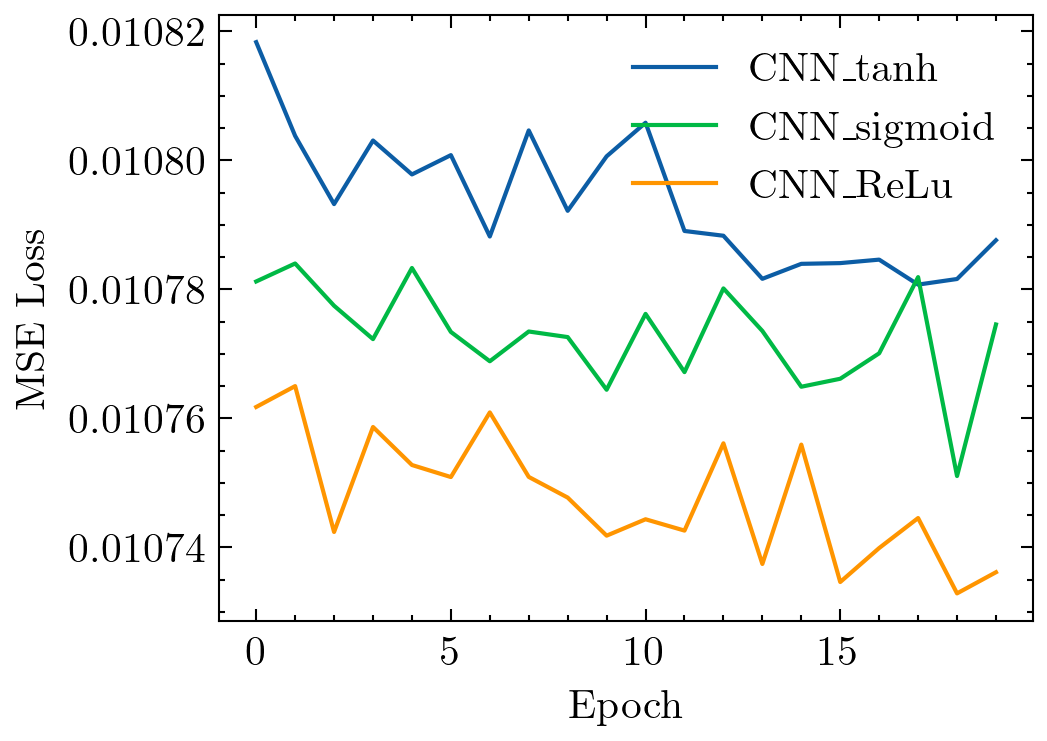

In [ ]:
with plt.style.context('science', 'ieee'):
    plt.rcParams['figure.dpi'] = 300
    plt.rcParams['savefig.dpi'] = 300
    plt.plot(train_loss_cnn_tanh, label='CNN_tanh')
    plt.plot(train_loss_cnn_sigmoid, label='CNN_sigmoid')
    plt.plot(train_loss_cnn_relu, label='CNN_ReLu')
    plt.xlabel('Epoch')
    plt.ylabel('MSE Loss')
    plt.legend()
    plt.show()